In [2]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import operator,json, re, itertools 
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud 
pd.options.display.max_colwidth = 300
import config
data_root= config.DATA_ROOT
tqdm.pandas()
import collect_tweets

In [58]:
df=pd.read_pickle(data_root+'tweets-priv.pkl')
print("# of privacy related tweets: {}\n# of unique users who tweeted:{}".format(len(df), len(df.author_id.unique())))

# of privacy related tweets: 216667
# of unique users who tweeted:90579


In [59]:
# df[['text', 'conversation_id']]
# reply= df[df.apply(lambda t: t.conversation_id!=int(t.name), axis=1)]
# print(reply.shape)
# reply.head()[['text', 'conversation_id']]

In [60]:
user_df = pd.read_pickle(data_root+'users-en-unique.pkl')
print('total # of users', len(user_df))

total # of users 1698096


In [61]:
deleted_users = set(df.author_id.unique()).difference(user_df.index)
print('# of users who tweeted sec-priv tweets but deleted their accounts:', len(deleted_users))
current_users = set(df.author_id).intersection(user_df.index)
print('# of users who tweeted sec-priv tweets and have their accounts:', len(current_users))
user_df=user_df.loc[list(current_users)]

# of users who tweeted sec-priv tweets but deleted their accounts: 26772
# of users who tweeted sec-priv tweets and have their accounts: 63807


In [62]:
'''remove tweets from deleted users as per TOS'''
df=df[df.apply(lambda row: row.author_id in current_users, axis=1)]
df.shape

(163658, 24)

In [63]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [64]:
df['search_grp'] = df.apply(lambda tweet: 
                            'mention' if tweet.search_term.startswith('@') \
                            else ('hashtag' if tweet.search_term.startswith('#') else 'other'), axis=1)

In [65]:
'''Parse the entities in a tweet object'''

pattern = re.compile('(?<!\\\\)\'')
def parse_entity(row):
    if isinstance(row.entities, str):
        try:
            return json.loads(pattern.sub('\"', row.entities))  
        except Exception as e:
            print(row.name, e)
            return {}
    else: 
        return {}
df['entities_parsed']= df.progress_apply(lambda row: parse_entity(row), axis=1)


 15%|█████                            | 25132/163658 [00:00<00:01, 74246.61it/s]

1470058531546148880 Expecting ',' delimiter: line 1 column 1007 (char 1006)


 48%|███████████████▏                | 77980/163658 [00:00<00:00, 106514.54it/s]

1452044410431016961 Expecting ',' delimiter: line 1 column 763 (char 762)
1467831133354217483 Invalid \escape: line 1 column 661 (char 660)
1493787553744310274 Expecting ',' delimiter: line 1 column 602 (char 601)
1458228916993380352 Expecting ',' delimiter: line 1 column 271 (char 270)
1458208238453805058 Expecting ',' delimiter: line 1 column 364 (char 363)
382891726043488256 Expecting ',' delimiter: line 1 column 616 (char 615)
308998244720058368 Expecting ',' delimiter: line 1 column 118 (char 117)
1305130606192406530 Expecting ',' delimiter: line 1 column 517 (char 516)
1432489026066518021 Expecting ',' delimiter: line 1 column 737 (char 736)
355879345279090688 Expecting ',' delimiter: line 1 column 143 (char 142)
425549454125461504 Expecting ',' delimiter: line 1 column 584 (char 583)


 55%|██████████████████               | 89414/163658 [00:01<00:01, 44001.40it/s]

1483802018963726343 Expecting ',' delimiter: line 1 column 819 (char 818)
438796915015446528 Expecting ',' delimiter: line 1 column 222 (char 221)
278885107962613760 Expecting ',' delimiter: line 1 column 520 (char 519)
1025727332177391617 Invalid \escape: line 1 column 766 (char 765)


 60%|███████████████████▋             | 97797/163658 [00:01<00:01, 39314.59it/s]

951022423977099264 Expecting ',' delimiter: line 1 column 783 (char 782)
580404413195530241 Expecting ',' delimiter: line 1 column 347 (char 346)
1267077115490549761 Expecting ',' delimiter: line 1 column 517 (char 516)
507641806289637376 Expecting ',' delimiter: line 1 column 398 (char 397)
1017392319249698817 Invalid \escape: line 1 column 766 (char 765)
1311729445502361602 Expecting ',' delimiter: line 1 column 517 (char 516)


 64%|████████████████████▍           | 104477/163658 [00:02<00:01, 37001.51it/s]

353117605533458432 Expecting ',' delimiter: line 1 column 501 (char 500)
1321486898838315013 Invalid \escape: line 1 column 615 (char 614)
1109076429612957697 Invalid \escape: line 1 column 766 (char 765)
1446190243837710374 Expecting ',' delimiter: line 1 column 581 (char 580)
378154867262767104 Expecting ',' delimiter: line 1 column 249 (char 248)


 70%|██████████████████████▍         | 114802/163658 [00:02<00:01, 34120.73it/s]

425915902597820416 Expecting ',' delimiter: line 1 column 110 (char 109)
1121337703025520640 Expecting ',' delimiter: line 1 column 111 (char 110)
1470790889425588226 Expecting ',' delimiter: line 1 column 819 (char 818)
352827246353981442 Expecting ',' delimiter: line 1 column 114 (char 113)
831873335252353024 Expecting ',' delimiter: line 1 column 478 (char 477)


 85%|███████████████████████████     | 138701/163658 [00:02<00:00, 56618.59it/s]

1333838215942377474 Expecting ',' delimiter: line 1 column 713 (char 712)
1434623591950192647 Expecting ',' delimiter: line 1 column 648 (char 647)
1387610858843361290 Expecting ',' delimiter: line 1 column 463 (char 462)
1254010266007801856 Expecting ',' delimiter: line 1 column 110 (char 109)
1492201526143729666 Expecting ',' delimiter: line 1 column 540 (char 539)
1492087485471637506 Expecting ',' delimiter: line 1 column 565 (char 564)
1446581223682416644 Expecting ',' delimiter: line 1 column 1155 (char 1154)
1470755533770694661 Expecting ',' delimiter: line 1 column 634 (char 633)
1483663578460790784 Expecting ',' delimiter: line 1 column 1970 (char 1969)


 98%|███████████████████████████████▍| 160748/163658 [00:02<00:00, 80406.81it/s]

1433493733618618372 Expecting ',' delimiter: line 1 column 632 (char 631)
1410253442698911751 Expecting ',' delimiter: line 1 column 632 (char 631)
1369317962738528264 Expecting ',' delimiter: line 1 column 632 (char 631)
1438157911545483264 Expecting ',' delimiter: line 1 column 685 (char 684)
1454144258508795910 Expecting ',' delimiter: line 1 column 602 (char 601)
1446475942201802753 Expecting ',' delimiter: line 1 column 1023 (char 1022)
1493321669905113090 Expecting ',' delimiter: line 1 column 906 (char 905)
1353456158107856896 Expecting ',' delimiter: line 1 column 115 (char 114)


100%|████████████████████████████████| 163658/163658 [00:02<00:00, 55144.92it/s]


In [66]:
keys = df.apply(lambda row: list(row.entities_parsed.keys()), axis=1)
keys=list(itertools.chain.from_iterable(keys.values))
len(keys),set(keys)

(104127, {'annotations', 'cashtags', 'hashtags', 'mentions', 'urls'})

In [67]:
df['urls'] = df.apply(lambda row: [urlparse(url['expanded_url']).netloc for url in row.entities_parsed['urls']] \
                      if 'urls' in row.entities_parsed else [], axis=1)
df['hashtags'] = df.apply(lambda row: [hashtag['tag'] for hashtag in row.entities_parsed['hashtags']] \
                      if 'hashtags' in row.entities_parsed else [], axis=1)
df['anno_type'] = df.apply(lambda row: [a['type'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['anno_text'] = df.apply(lambda row: [a['normalized_text'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['mentions'] = df.apply(lambda row: [m['username'] for m in row.entities_parsed['mentions']] \
                      if 'mentions' in row.entities_parsed else [], axis=1)

In [68]:
def entity_stat(df, common=5):
    print('Number of tweets with url(s):', len(df[df.apply(lambda row: len(row.urls)>0, axis=1)]))
    print('Number of tweets with hashtag(s):', len(df[df.apply(lambda row: len(row.hashtags)>0, axis=1)]))
    print('Number of tweets with annotations(s):', len(df[df.apply(lambda row: len(row.anno_type)>0, axis=1)]))
    print('Number of tweets with mention(s):', len(df[df.apply(lambda row: len(row.mentions)>0, axis=1)]))
    print()
    mentions = list(itertools.chain.from_iterable(df.mentions.values))
    tags=list(itertools.chain.from_iterable(df.hashtags.values))
    urls=list(itertools.chain.from_iterable(df.urls.values))
    anno_type=list(itertools.chain.from_iterable(df.anno_type.values))
    anno_text=list(itertools.chain.from_iterable(df.anno_text.values))
    print('urls: {}, unique:{}, most_common:{}'.format(len(urls), len(set(urls)), Counter(urls).most_common(common)))
    print('mentions: {}, unique:{}, most_common:{}'.format(len(mentions), len(set(mentions)), Counter(mentions).most_common(common)))
    print('tags: {}, unique:{}, most_common:{}'.format(len(tags), len(set(tags)), Counter(tags).most_common(common)))
    print('anno_type: {}, unique:{}, most_common:{}'.format(len(anno_type), len(set(anno_type)), Counter(anno_type).most_common(common)))
    print('anno_text: {}, unique:{}, most_common:{}'.format(len(anno_text), len(set(anno_text)), Counter(anno_text).most_common(common)))

In [69]:
entity_stat(df , common=10)

Number of tweets with url(s): 40495
Number of tweets with hashtag(s): 41734
Number of tweets with annotations(s): 6641
Number of tweets with mention(s): 15229

urls: 50803, unique:3012, most_common:[('twitter.com', 11114), ('bit.ly', 8829), ('ow.ly', 6443), ('buff.ly', 2514), ('hubs.ly', 1437), ('gag.gl', 897), ('stwb.co', 858), ('okt.to', 799), ('goo.gl', 772), ('lnkd.in', 591)]
mentions: 22508, unique:7866, most_common:[('ZDNet', 225), ('EdTech_K12', 220), ('CIOonline', 206), ('InfosecurityMag', 205), ('ITProPortal', 175), ('NTTComSec_UK', 168), ('helpnetsecurity', 161), ('SearchSecurity', 158), ('CSOonline', 150), ('MdMisi', 131)]
tags: 144338, unique:10314, most_common:[('BYOD', 33567), ('security', 12826), ('cybersecurity', 5269), ('byod', 4099), ('infosec', 4079), ('mobile', 3650), ('privacy', 1550), ('mobilesecurity', 1463), ('IoT', 1443), ('Cybersecurity', 1400)]
anno_type: 8094, unique:5, most_common:[('Organization', 3338), ('Person', 1784), ('Product', 1587), ('Place', 1183)

In [70]:
# t=df[df.apply(lambda row: 'twitter.com' in row.urls[0] if row.urls else False, axis=1)]
# pd.options.display.max_colwidth=390
# t[['text']]
df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'search_grp', 'entities_parsed', 'urls', 'hashtags', 'anno_type',
       'anno_text', 'mentions'],
      dtype='object')

In [71]:
def get_tweet_type(tweet):
    for url in tweet.urls:
        if 'twitter.com' in url:
            return 'quote'
    if int(tweet.name)!=tweet.conversation_id:
        return 'reply'
    return 'novel'

df['tweet_type'] = df.apply(lambda tweet: get_tweet_type(tweet), axis=1)

In [72]:
df.groupby('tweet_type').text.count()

tweet_type
novel    134345
quote     11010
reply     18303
Name: text, dtype: int64

## Who tweeted? Find user groups

In [73]:
uids = set(user_df.index)
df['author_group'] = df.progress_apply(lambda row: user_df.loc[row.author_id].user_group if row.author_id in uids else 'Unknown', axis=1)

100%|████████████████████████████████| 163658/163658 [00:10<00:00, 15858.95it/s]


In [18]:
df.groupby(['author_group', 'tweet_type']).text.count().sort_values(ascending=False).to_frame().head(10)

,,text
author_group,tweet_type,
unknown,novel,42895
business_brand,novel,37212
personal_brand,novel,17845
academic_techi,novel,15711
news,novel,11315
unknown,reply,10063
academic,novel,6078
business_brand,quote,5695
techie,novel,3289


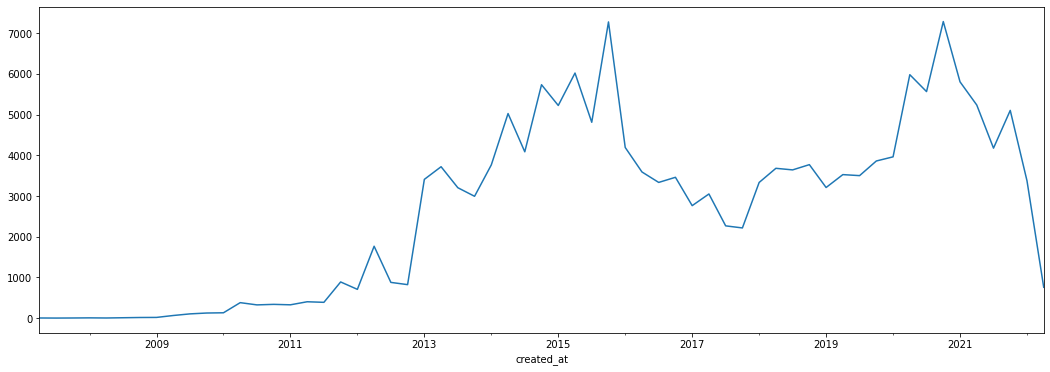

In [19]:
plt.figure(figsize=(18,6))
df.reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot()
plt.title('')
plt.show()

## Tweet sentiment

In [20]:
# def remove_comp(senti):
#     if 'compound' in senti:
#         senti.pop('compound')
#     return senti
# df['senti2'] = df.apply(lambda tweet: remove_comp(tweet.senti), axis=1)
# df['senti2'] = df.apply(lambda tweet: max(tweet.senti2.items(), key=operator.itemgetter(1))[0], axis=1)

In [21]:
df.groupby('senti').text.count()

senti
negative      7309
neutral     148082
positive      8267
Name: text, dtype: int64

In [22]:
df.groupby(['tweet_type','senti']).text.count()#.sort_values(ascending=False)

tweet_type  senti   
novel       negative      5651
            neutral     121958
            positive      6736
quote       negative       193
            neutral      10318
            positive       499
reply       negative      1465
            neutral      15806
            positive      1032
Name: text, dtype: int64

In [23]:
df[df.senti=='negative'].groupby(['author_group']).text.count().sort_values(ascending=False)

author_group
unknown           3545
business_brand    1327
academic_techi     823
personal_brand     579
news               451
academic           413
techie             171
Name: text, dtype: int64

In [24]:
neg_df = df[df.senti=='negative']

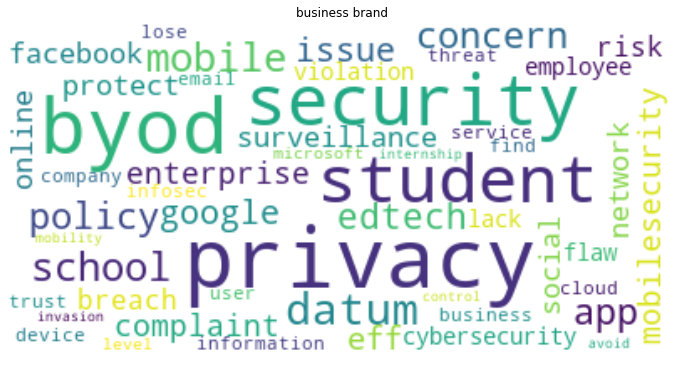

In [25]:
plt.figure(figsize=(12,8))
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", collocations=False).generate(
    ' '.join([text for text in neg_df[neg_df.author_group=='business_brand'].text_clean_senti.values]))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('business brand')
plt.show()

In [26]:
'''tweets from business brands related to certain keywords'''
def contains_keywords(kws, text):
    for kw in kws:
        if kw in text:
            return True
    return False
business = neg_df[neg_df.author_group=='business_brand']
business[business.apply(lambda row: contains_keywords(['student', 'school', 'edtech'], row.text_clean_topic), axis=1)][['text']]

,text
tweetid,
1287655300322000898,Exploitation Cyber Security Course ($94.99 to Free) #100daysofcode #jobs #bugs #exploits #bounty #vulnerability #security #Internet #networking #programming #codenewbie #coding #womenwhocode #developer #code #career #onlinecourse #edtech #elearning #learn https://t.co/tIv4WR7D6R
1461765913171173394,This week in privacy!\n\n✳️ Can Web3 help to protect human rights?: https://t.co/yQAleU4nMT\n✳️ How GoGuardian student spyware took over schools: https://t.co/pnlSq9bIi3\n✳️ Music artists protest Amazon palm scanners at venues: https://t.co/FJn80v2sX1 https://t.co/DbEQhlTdpB
557132213020803072,"""@Windows_agent: Safeguarding #student #privacy http://t.co/zuzswJCfuz #windows"""
172365409146765312,Trial begins in case of Rutgers student who filmed gay roommate http://t.co/U48LYJl9 #privacy #legalnews #Rutgers
1075103197478440960,Back to basics: Student Privacy 101 #studentprivacy https://t.co/fbBg13hqFn
...,...
499624051828981761,#FireNews Student newspaper sues Purdue over video surveillance tape…: http://t.co/wkA0vbUZkB #SecurityNews
803760624907984896,What a Judge Doesn’t Understand About Digital Privacy May Harm Your Children via @AEI https://t.co/kMc6AVgaQv #studentprivacy #eddata
925342307838300161,At #EDU17 this week and interested in #highered #studentprivacy? Let me know if you want to grab coffee! #eddata #edtech #edchat


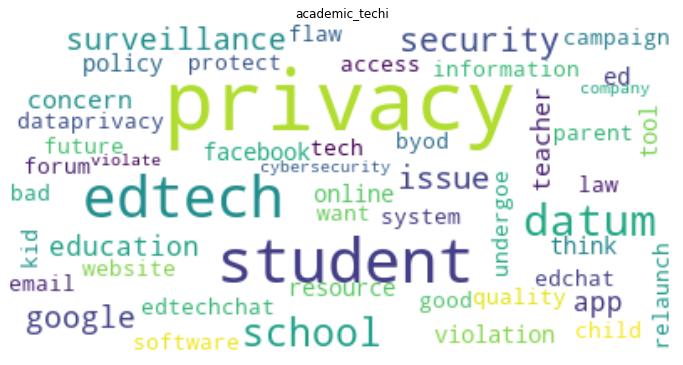

In [27]:
plt.figure(figsize=(12,8))
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", collocations=False).generate(
    ' '.join([text for text in neg_df[neg_df.author_group=='academic_techi'].text_clean_senti.values]))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('academic_techi')
plt.show()

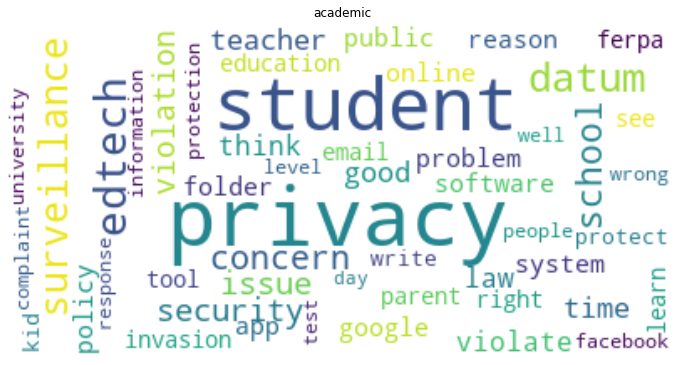

In [28]:
plt.figure(figsize=(12,8))
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", collocations=False).generate(
    ' '.join([text for text in neg_df[neg_df.author_group=='academic'].text_clean_senti.values]))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('academic')
plt.show()

In [29]:
sample1 = pd.read_excel('priv-tweets-neg-sample1.xls')
sample1.tweetid = sample1.tweetid.astype(str)
sample1.set_index('tweetid', inplace=True)

In [30]:
df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]

/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/1178873254.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]


,text
tweetid,
388933694498406400,No Recourse for Girls Harassed by Transgender Bully http://t.co/XI0FlCUhAb CO girls' privacy jeopardized by one gender confused moron=wrong
25920117445,I'm truly horrified by the circumstances of this young Rutgers student's invasion of privacy and subsequent suicide. http://bit.ly/bKaQBj
27787390340833280,"Teacher Punished for Reporting Violent 7-Year-Old: http://abcn.ws/eP17QU. Did she violate the student's privacy, or do the right thing?"
1455170658371977226,@CheetahJim1 @ProFootballTalk Not saying it's right to violate one's privacy but where were y'all when Linda Tripp was violating Monica Lewinski? People get violated by the system every day. Your typical college rape of a student by a professor involves far more violation than poor millionaire...
1337484131928862727,This is why I get mad when edtech or tech platforms get applauded \n\nNo one EVER asks what the fuck is going on in schools with privacy \n\nAnd let me tell you it is a mess because half the staff don’t know and the other half are wannabe prison guards https://t.co/GRkU0cBfHH
1122934665122320384,A student cleared of rape when his accuser’s text messages proved his innocence said this morning that rape suspects deserve the same right to privacy as victims https://t.co/rt13k0DI34
1025695617048301568,"@BostonDotCom WTF? This is disgusting. She's a student that work hard to get into college and she gets target b/c she a person of color and they're worried about the ""privacy laws"" after this young woman got humiliated for doing nothing wrong. Get the hell out here with that BS."
180695154313805824,"Dharun Ravi, ex Rutgers Univ student was found guilty on charges of invasion of privacy, but not guilty charges of bias intimidation"
9293828456,"Absolutely horrifying: ""School used student laptop webcams to spy on them at school and at home"" http://bit.ly/apfgRf #privacy"


In [31]:
df[df.senti=='negative'].sample(10)[['text']]

,text
tweetid,
101695842209107968,Court sides with college accused of snooping on student’s email account http://e74.us/8w #privacy RT @internetcases &lt; Unencrypted = insecure
344785106378043393,BYOD &amp; the implications for the IT team http://t.co/SM6MAuiqkB #tech #news #BYOD #mobile #IT #security
941678592970379265,See how @usedgov now investigating @MoskowitzEva &amp; @SuccessCharters for violations of student privacy #FERPA @MarkTreyger718 @Parents4Privacy @FatimaFarax @NYCKidsPAC @jbelluck @CoreyinNYC @Dromm25 @ChalkbeatNY @NYDNBenChapman @katetaylornyt https://t.co/d0PYXySLy9
289560706506969088,School privacy policies are dangerous. Coworker was not allowed to learn name of student who fractured son's skull due to privacy policy.
1336323095565459461,"@susanoha Some edtech is great and others are an abomination, digiLEARN is selling the abomination edtech that is expensive, sunders privacy and harms children. https://t.co/WYSvU3mEM8"
1325974559506522112,"@PublixHelps The chairs to the right in the grocery store was where 2 people in the pharmacy, first a student and then the pharmacist, tried to give me the flu vaccine. I refused because this is unacceptable. No privacy. Pathetic pt care! https://t.co/t4O0wn4MPf"
854077533104427008,MT @TeriGRight: #CommonCore intrusive data mining threatens student privacy! #KeepYourPromise #StopCommonCore https://t.co/6xyB74ntJa #PJNET
1101672288985014272,The latest Hecht Hyperborean! https://t.co/YJKNCaAxez Thanks to @catacalypto @twmillar @nevesytrof #privacy #edtech
310032618819297281,"Allure of ""21st-century technology"" masks privacy-undermining agenda of those allergic to..parental autonomy. http://t.co/gMGlL2xZk4"


### Topics

In [32]:
priv_topics = [line.split(':')[1] for line in open('priv-tweet-topics.txt')]
for pt in range(len(priv_topics)):
    print(pt, priv_topics[pt].strip())

0 gauge pseudonym tyranny culprit sarcasm ludicrous nefarious pedophile disingenuous fwiw
1 edtech cybersecurity dfir skillsgap nlproc ingramtechsol systemsthinke stcenturyskill thecybersecurityplace cybint
2 datum protect sotu schoolprivacyzone paigekowalski datadrivesresult rachelbarrer takectrl replukemesser benjaminbherold
3 username share talk story daily event awesome tune david advisor
4 school lifeleader schoolchildren safeschool studentvoice chooseprivacy schooldistrict coetail powerschool indyschool
5 security byod mobile device enterprisesecurity byodsecurity fiercemobileit securityrisk dellsecurity symantec
6 privacy student news washington priva myname privac stud studentright priv
7 facebook internship flaw austrian lose harvard expose highlight messenger cancel
8 conclude cpdp myriad minefield txcto asugsv sotn bettertogether nuisance rundown
9 neighborhood georgetown auburn nazi chattanooga tulsa knife sixth uconn franklin


In [33]:
interesting_topics=[0, 1,2 ,3,4,6]
# 0: talks about tyranny of EdTech
# 1: ingramtechsol, thecybersecurityplace, cybint-->general cybersecurity, 
# 2: names of politicians, journalists who talk about (privacy?) policy
# 3: news, articles, announcements, some about how to prevent security/privacy issues 
# 4: similar to 0
# 5: about BOYD, ignore

In [34]:
df.groupby('topic').text.count().sort_values(ascending=False).head(10)

topic
 6    104699
 5     37108
 1     12735
 3      6447
 2      1205
 4       702
-1       699
 7        48
 0        12
 9         3
Name: text, dtype: int64

### Sample negative tweets for each topic for manual annotation 

In [35]:
neg_df = df[df.senti=='negative']
neg_df['link']=neg_df.apply(lambda r: 'http://twitter.com/u/status/{}'.format(r.name), axis=1)
neg_df.groupby('topic').text.count().sort_values(ascending=False).head(10)

/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/416443871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['link']=neg_df.apply(lambda r: 'http://twitter.com/u/status/{}'.format(r.name), axis=1)


topic
 6    6003
 5     830
 3     241
 1     144
 4      34
-1      24
 2      21
 7       7
 0       5
Name: text, dtype: int64

In [36]:
neg_df[neg_df.topic<5][['text', 'link']].to_excel('neg-tweet-[0-4].xls')

/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/3295617127.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  neg_df[neg_df.topic<5][['text', 'link']].to_excel('neg-tweet-[0-4].xls')


In [37]:
tdf= df[df.apply(lambda row: row.topic==5 and 'edtech' in row.text.lower(), axis=1)]
print(len(tdf))
tdf[['text']].to_excel('neg-tweet-5.xls')
tdf.sample(np.min([10,len(tdf)]))[['text', 'topic','topic_cos','created_at']]

373


/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/4159211947.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  tdf[['text']].to_excel('neg-tweet-5.xls')


,text,topic,topic_cos,created_at
tweetid,,,,
734971820550586368,Custom #App stores: How #FedIT balances #security w/ #BYOD &amp; apps @ORNL @NGA_GEOINT https://t.co/AbmkpvjoqR via @FedTechMagazine,5,8,2016-05-24 04:58:31+00:00
1428558017956622339,Ep 228 NFT Rock Bargains\nhttps://t.co/SQhSn5wRM6\n\n@techsavvyteach &amp; @wfryer discuss #PrintNightmare #Ransomware #security #tmobilehack #TMobileDataBreach #NFTs #Facebook #outrage #TechCorrection #SocialMedia @Moonalice #Windows11 #googleEDU #edtech #Chromebooks #AntiVax &amp; more! https:...,5,8,2021-08-20 03:22:27+00:00
548509395408408577,School Security And Mobile Access: Making Them Work Together http://t.co/f11BJzDt2V\n#BYOD #security #edtech_K12 http://t.co/yKeap4fAp8,5,5,2014-12-26 16:03:25+00:00
1043594551913578498,"According to @EdTech_K12, #IoT and #IT professionals should take an interdisciplinary approach to #security in order to create a more resilient connected network of devices and systems https://t.co/gjjG8ZG2gm",5,8,2018-09-22 20:15:04+00:00
1273291937030774785,Chromebooks face the same cyber attacks associated with laptops and mobile devices without the same security. Join us on 7.8 at 11am EDT for a talk and demo of attacks. https://t.co/J1WiBGNMEA #Chromebooks #edtech #cybersecurity #K12 #DistanceLearning #RemoteSchool #infosec https://t.co/MposENMQ3w,5,1,2020-06-17 16:30:29+00:00
1334500246215340037,"Chromebooks, the devices of choice for many #K12 schools, have built-in security features. Are schools making the most of them? #edtech via @EdTech_K12 https://t.co/Y9cHt8MbNd",5,4,2020-12-03 14:10:27+00:00
296645353124532226,Going to #fetc? Come to booth #1503 and see @enterasys &amp; iBoss in action! #security #edtech and #byod done right! http://t.co/wHcDWc90,5,8,2013-01-30 15:45:38+00:00
613782703519965188,"Despite the security challenges, #BYOD will bring plenty of benefits to your school, if you're ready - http://t.co/KhRk6sMDls #edtech",5,8,2015-06-24 18:56:14+00:00
896886468395671553,EdTech_K12: #BYOD for #k12 students and teachers doesn't have to compromise #security. https://t.co/I1OLA1Anon #caedchat,5,4,2017-08-14 00:09:32+00:00


#### Who tweeted under Topic 5?

In [38]:
len(df[df.apply(lambda row: row.topic==5 and 'byod' in row.text.lower(), axis=1)])/len(df)

0.20649769641569615

In [39]:
len(neg_df[neg_df.apply(lambda row: row.topic==5 and 'byod' in row.text.lower(), axis=1)])/len(neg_df)

0.10452866329183198

In [40]:
neg_df[neg_df.topic==5].groupby('author_group').text.count()

author_group
academic            5
academic_techi     26
business_brand    524
news               29
personal_brand    107
techie             29
unknown           110
Name: text, dtype: int64

In [41]:
neg_df[(neg_df.topic==5)&((neg_df.author_group=='academic') | (neg_df.author_group=='academic_techi'))].sample(10)[['text', 'created_at']]

,text,created_at
tweetid,,
605472122476064768,New measures to tighten mobile network security http://t.co/3dHVHjhZsc via @ecampusnews #mlearning #edchat,2015-06-01 20:32:57+00:00
446642988614418432,"Cheap #apps, lack of inbuilt security leaves #mobile environment vulnerable | @scoopit http://t.co/rSLZdWhCIK #MobileSecurity #BYOD #EDU",2014-03-20 13:42:41+00:00
405605350130601985,"I so want to believe this MT @simfin: Why BYOD actually increases security, based on recent findings by Sophos http://t.co/b8yAVNn8nW #byod",2013-11-27 07:53:45+00:00
779024323856195584,Largest corporate security weakness is your phone and #BYOD. https://t.co/5Vqpd6PAvx #CyberAware,2016-09-22 18:27:27+00:00
1287635108615331841,Exploitation Cyber Security Course ($94.99 to Free) #100daysofcode #jobs #bugs #exploits #bounty #vulnerability #security #Internet #networking #programming #codenewbie #coding #womenwhocode #developer #code https://t.co/FcdKJBLVdH,2020-07-27 06:25:07+00:00
1205570604902027264,Ethical hacking is a term used to describe hacking performed by an individual to help identify potential threats on a computer or network. \n\nAvail Ethical Hacking Bundle: https://t.co/Y1rj4nXWrM\n\n#eduonix #elearning #onlinecourses #ethicalhacking #networksecurity,2019-12-13 19:30:05+00:00
370896370670268416,"@J_Fedosoff Yes! So energized from #TLDWpeel but have questions about security, logistics, parental expectations/limitations, ETFO #BYOD",2013-08-23 13:12:40+00:00
98570525693054977,Apple updates for iOS and iWork '09 fix 4 security flaws: http://t.co/UBd6Dg0 #ipad #mlearning,2011-08-03 01:46:59+00:00
1285239791160827904,The rise of BYOD is an IT departments worst nightmare. How can you provide your employees with the applications and tools they require to effectively carry out their jobs across multiple platforms while still maintaining security? 👀 https://t.co/j1yW3FBiC6\n\n#BYOD #workplace,2020-07-20 15:46:59+00:00


#### Who tweeted under topic 6?

In [42]:
neg_df[neg_df.topic==6].groupby('author_group').text.count()

author_group
academic           374
academic_techi     718
business_brand     735
news               402
personal_brand     434
techie             120
unknown           3220
Name: text, dtype: int64

In [43]:
df[(df.topic==6)&(df.author_group=='academic')].sample(10)[['text', 'created_at']]

,text,created_at
tweetid,,
1106194542057918466,"Edtech leaders nudge Congress on grant funding, student data privacy | EdScoop https://t.co/2yPqQA5fVH",2019-03-14 14:05:05+00:00
1121943322501832705,"@thelonevirologi @ECDC_Flu Also, thank you so much for tweeting flu surveillance data. I am a grad student in a flu surveillance lab, so I find your tweets useful !",2019-04-27 01:05:07+00:00
1395030215965949952,"@coolcatteacher For privacy reasons, I cannot share the student videos, but let me see about finding some still photos.",2021-05-19 14:54:56+00:00
180684951363141632,"BREAKING: NEW BRUNSWICK, N.J. (AP) — Ex-Rutgers student convicted of #hatecrime, invasion of privacy in webcam spying case.",2012-03-16 16:00:24+00:00
1247865986650341376,"I mean, maybe everyone's doing the work and getting each individual student in the class to waive their right to privacy and allow the publication of an educational record. But I'd be surprised if that's the case.",2020-04-08 12:36:50+00:00
1304254892417134592,@estrickteach @ivykongpm @MsMessineo @Flipgrid That is great. I also have some students who don't like to have their peers watch them. I like that option for privacy as well.,2020-09-11 03:06:12+00:00
1478112255225040904,"“Instead, we face an awkward situation where many universities are performing thousands of tests a day on young, vaccinated, and largely healthy student populations while high-risk individuals and their caregivers struggle to keep up with surveillance.”",2022-01-03 21:13:18+00:00
442897699000832000,Share these tips with your Ss! MT @mbkudrna: 11 Tips For Students To Manage Their Digital Footprints http://t.co/smntfawQiy #edtech #privacy,2014-03-10 05:40:14+00:00
535094654337691648,The life of #data and data privacy... #edtech http://t.co/zXoYCzVodb,2014-11-19 15:38:01+00:00


In [44]:
df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'search_grp', 'entities_parsed', 'urls', 'hashtags', 'anno_type',
       'anno_text', 'mentions', 'tweet_type', 'author_group'],
      dtype='object')

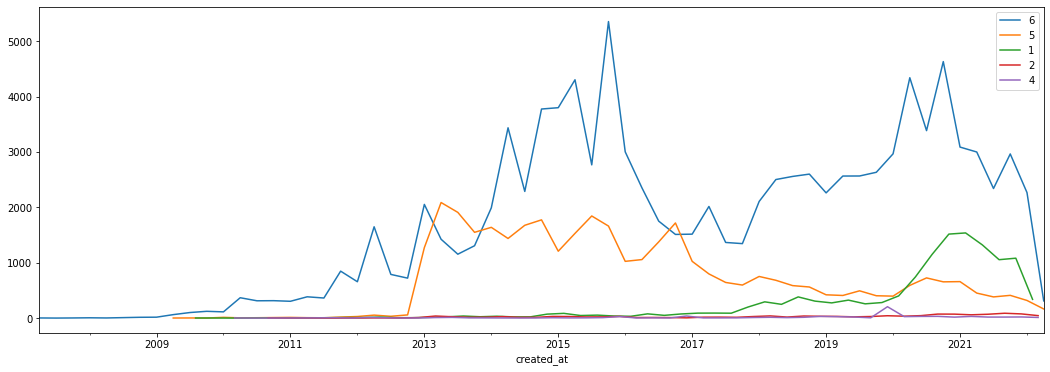

In [45]:
plt.figure(figsize=(18,6))
for topic in [6,5,1,2, 4]:
    df[df.topic==topic].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label=str(topic))
# df[df.topic==15].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 15')
# df[df.topic==10].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 10')
# df[df.topic==1].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 1')
# df[df.topic==8].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 8')
# df[df.topic==19].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 19')
plt.legend()
plt.show()

### remove duplicate tweets

In [36]:
topic_6 = pd.read_excel('neg-tweet-6-final.xlsx')#pd.concat([pd.read_excel('neg-tweet-6.xlsx').iloc[:1753], pd.read_excel('neg-tweet-6-no-dup.xlsx')[1753:]])
print(topic_6.shape)
dups = [line.strip() for line in open('duplicates.txt')][0].split(',')
dups=list(filter(None, dups))
dup_tweets = []
for dup in dups:
    dup_tweets += list(topic_6[topic_6.apply(lambda row: dup.strip().lower() in row.text.lower() and \
                                             (isinstance(row.Code1, float) or len(row.Code1)==0), axis=1)].index)
len(dup_tweets)

(4613, 4)


50

In [37]:
dups[1]#.strip()

' obama'

In [38]:
no_dup=topic_6.drop(index=dup_tweets)
print(no_dup.shape)
no_dup[['text','Code1', 'link']].to_excel('neg-tweet-6-final.xlsx')

(4563, 4)


### Examine Tweets after manual labelling

In [46]:
labeled_df = pd.read_excel('neg-tweet-(0-4).xlsx', converters={'tweetid' : str})

/Users/rhasan3/work/edtech-scrape/edenv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [47]:
labeled_df['tweetid'] = labeled_df.apply(lambda r: r.link.split('/')[-1], axis=1) #tweetid.astype(str)
labeled_df.set_index('tweetid', inplace=True)

In [48]:
labeled_df['text_clean'] = df.loc[labeled_df.index].text_clean_topic

In [49]:
labeled_df.groupby('Code1').text.count().sort_values(ascending=False)

Code1
privacy-specific         116
privacy-generic           72
other                     63
other-privacy             40
article                   28
edtech-generic            25
info_brand                21
tech_brandi               14
privacy incident          12
edtech-ques                9
other-student-privacy      8
Name: text, dtype: int64

In [50]:
def get_tfidf_top_features(documents,n_top=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]


In [51]:
# tfidf = TfidfVectorizer(stop_words='english')
# corpus=list(labeled_df[(labeled_df.Code1=='privacy-specific')|(labeled_df.Code1=='privacy-generic')].text.values)
# tfidf_model = tfidf.fit_transform(corpus)
# feature_names = np.array(tfidf.get_feature_names())

In [52]:
corpus=list(labeled_df[(labeled_df.Code1=='privacy-specific')|(labeled_df.Code1=='privacy-generic')].text_clean.values)
top_words = (get_tfidf_top_features(corpus, n_top=20))
np.array(top_words)

/Users/rhasan3/work/edtech-scrape/edenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['username', 'surveillance', 'security', 'edtech', 'school',
       'issue', 'software', 'bad', 'datum', 'app', 'exam', 'kid',
       'cybersecurity', 'breach', 'pay', 'account', 'password', 'zoom',
       'people', 'company'], dtype='<U17')

In [53]:
'''Now find tweets in topic 6 category containing above keywords'''
topic_6 = neg_df[neg_df.topic==6]
topic_6.shape

(6003, 34)

In [54]:
drop_words=['internship', 'austrian', 'rutger', 'byod']
topic_6 = topic_6[topic_6.apply(lambda row: len(set(row.text.lower().split()).intersection(drop_words))==0, axis=1)]
topic_6['link'] = topic_6.apply(lambda row: 'https://twitter.com/u/status/{}'.format(row.name), axis=1)
topic_6.shape

(5808, 34)

In [57]:
# topic_6.sample(frac=1)[['text', 'link']].to_excel('neg-tweet-6.xlsx')

### Analyze labelled tweets

In [75]:
labled_df = pd.concat([pd.read_excel('neg-tweet-6.xlsx').iloc[:1270], pd.read_excel('neg-tweet-(0-4).xlsx')])
labled_df.tweetid = labled_df.tweetid.astype(str)
labled_df['tweetid'] = labled_df.apply(lambda row: row.link.split('/')[-1], axis=1)
labled_df = labled_df[labled_df.apply(lambda row: isinstance(row.Code1, str) and len(row.Code1.strip())>2, axis=1)]
labled_df.set_index('tweetid', inplace=True)
labled_df.shape

/Users/rhasan3/work/edtech-scrape/edenv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


(1380, 4)

In [76]:
df=df.loc[labled_df.index]
df['code']=labled_df.Code1

df.groupby('code').text.count().sort_values(ascending=False)

code
privacy-specific         271
other-student-privacy    205
privacy-generic          169
other-privacy            161
article                  146
other                    130
privacy incident          84
policy                    79
edtech-generic            36
info_brand                36
tech_brandi               33
edtech-ques               30
Name: text, dtype: int64

#### who tweeted them?

In [82]:
df.groupby(['author_id']).text.count().sort_values(ascending=False).head(10)

author_id
36991951               22
118530377              17
224059040               9
182539117               8
19895837                8
2299828074              7
1331274208475820037     7
7044082                 7
15694680                6
216928966               6
Name: text, dtype: int64

In [80]:
df.groupby(['code', 'author_group']).text.count().sort_values(ascending=False).head(10)

code                   author_group  
privacy-specific       unknown           145
other-student-privacy  unknown           128
privacy-generic        unknown            83
other-privacy          unknown            79
other                  unknown            77
privacy-specific       academic_techi     54
article                unknown            52
policy                 unknown            39
privacy incident       unknown            38
privacy-generic        academic_techi     36
Name: text, dtype: int64

In [54]:
df.groupby('code').retweets.mean().sort_values(ascending=False)

code
privacy-specific         7.110701
privacy-generic          2.183432
article                  1.616438
info_brand               1.555556
other-privacy            1.217391
policy                   1.075949
other-student-privacy    0.902439
privacy incident         0.857143
tech_brandi              0.757576
other                    0.684615
edtech-ques              0.400000
edtech-generic           0.361111
Name: retweets, dtype: float64

In [55]:
df.groupby('code').likes.mean().sort_values(ascending=False)

code
privacy-specific         16.623616
privacy-generic           5.656805
other-privacy             3.360248
other-student-privacy     3.117073
other                     2.630769
privacy incident          2.428571
article                   2.191781
edtech-generic            1.861111
info_brand                1.777778
policy                    1.392405
tech_brandi               1.121212
edtech-ques               0.666667
Name: likes, dtype: float64